# Bias in Face Recognition

In this notebook we'll demonstrate the not-so-surprising fact that if your training data has few samples of some groups, the performance of your model on these groups would be worse than the general performance. It's based on the [Face Recognition example in ScikitLearn](https://scikit-learn.org/0.16/auto_examples/applications/face_recognition.html), using the Labeled Faces in the Wild (LFW) people dataset and showing gender bias (assuming binary gender).

In [165]:
import os 
import math
import logging

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import gender_guesser.detector as gender

from time import time
from collections import defaultdict

from sklearn.datasets import fetch_lfw_people
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

## Preprocessing

Download the data, if not already on disk and load it as numpy arrays. 

In [166]:
lfw_people = fetch_lfw_people(resize=0.4, min_faces_per_person=5)

n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 5985
n_features: 1850
n_classes: 423


Next, we use a "gender guesser" to estimate how many females vs. how many males we have in the dataset. 
We'll print some examples to see if it's accurate enough, and remove gender-neutral names.

In [167]:
gender_detector = gender.Detector()
genders = {name: gender_detector.get_gender(name.split()[0]) for name in target_names}

males = [name for name, gender in genders.items() if gender == 'male']
females = [name for name, gender in genders.items() if gender == 'female']

# Count the number of total samples per gender
samples_per_person = defaultdict(int)

for label in y.tolist():
    samples_per_person[target_names[label]] += 1
    
percent = {}
for curr_gender in ['male', 'female', 'unknown']:
    curr_names = [name for name, g in genders.items() if g == curr_gender]
    curr_n_samples = sum([samples_per_person[name] for name in curr_names])
    percent[curr_gender] = curr_n_samples * 100.0 / n_samples
    
print('Estimated: males = {:.2f}%, females = {:.2f}%, unknown = {:.2f}%'.format(percent['male'], 
                                                                                percent['female'], 
                                                                                percent['unknown'])) 
print('==========================================================')
print('\n'.join([': '.join((name, gender)) for name, gender in list(genders.items())[:10]]))

Estimated: males = 73.88%, females = 15.82%, unknown = 5.83%
Abdullah Gul: male
Adrien Brody: male
Ahmed Chalabi: male
Ai Sugiyama: female
Al Gore: male
Al Sharpton: male
Alan Greenspan: male
Alastair Campbell: male
Albert Costa: male
Alejandro Toledo: male


Unsurprisingly there is more representation for males than for females in the dataset. However, we will make it even less balanced by sampling the 10 males with the most samples and 10 females with the least samples. 

In [169]:
samples_per_males = sorted([(name, samples_per_person[name]) for name in males], 
                           key=lambda x: x[1], reverse=True)
samples_per_females = sorted([(name, samples_per_person[name]) for name in females], 
                             key=lambda x: x[1], reverse=True)

NUM_MALES = 10
NUM_FEMALES = 10

male_classes = set([name for name, _ in samples_per_males[:NUM_MALES]])
female_classes = set([name for name, _ in samples_per_females[-NUM_FEMALES:]])
all_classes = male_classes.union(female_classes)
indices_of_targets = list([i for i in range(n_classes) if target_names[i] in all_classes])
index_map = {old: new for new, old in enumerate(indices_of_targets)}

X = np.vstack([X[i,:] for i in range(X.shape[0]) if y[i] in set(indices_of_targets)])
y = np.array([index_map[label] for label in y.tolist() if label in index_map])
target_names = [target_names[old_index] for old_index in indices_of_targets]
print('\n'.join(target_names) + '\n')
assert(X.shape[0] == y.shape[0])

n_classes = len(target_names)
n_samples = X.shape[0]

percent = {}
for curr_gender, curr_samples in zip(['male', 'female'], 
                                     [samples_per_males[:NUM_MALES], samples_per_females[-NUM_FEMALES:]]):
    _, curr_n_samples = zip(*curr_samples)
    percent[curr_gender] = sum(curr_n_samples) * 100.0 / n_samples
    
print('Estimated: males = {:.2f}%, females = {:.2f}%\n'.format(percent['male'], percent['female'])) 
print(f'n_samples: {n_samples}')
print(f'n_classes: {n_classes}')

Ariel Sharon
Colin Powell
Donald Rumsfeld
George W Bush
Gerhard Schroeder
Hugo Chavez
Jean Chretien
John Ashcroft
Junichiro Koizumi
Nadia Petrova
Natalie Maines
Nia Vardalos
Pamela Anderson
Princess Caroline
Queen Rania
Sharon Stone
Steffi Graf
Tony Blair
Vanessa Redgrave
Victoria Clarke

Estimated: males = 96.68%, females = 3.32%

n_samples: 1506
n_classes: 20


Let's just print some people's images along with their names, to make sure we didn't mess up.

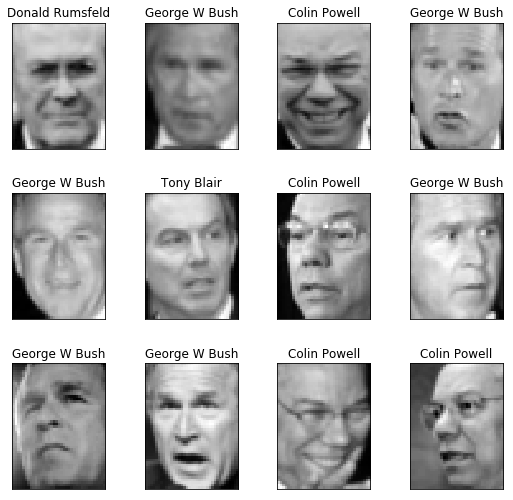

In [170]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=0.35)
    for i in range(n_row * n_col):
        if i == len(images):
            break
            
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(X[:12], [target_names[y[i]] for i in range(12)], h, w)

Looks good. 

## Training

Split into a training set and a test set, and make sure they contain exactly the same classes.

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
while set(y_train) != set(y_test):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

Train a simple MLP classifier with 2 hidden layers. 

In [172]:
print("Fitting the classifier to the training set")
t0 = time()
clf = MLPClassifier(hidden_layer_sizes=(n_features, n_features//2), random_state=1)
clf.fit(X, y)
print("done in %0.3fs" % (time() - t0))

Fitting the classifier to the training set
done in 84.891s


## Evaluation 

Here we follow the same evaluation from the original example and compute the $F_1$ score across the entire test set. 

In [173]:
y_pred = clf.predict(X_test)
assert(y_pred.shape == y_test.shape)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print('precision = {:.3f}, recall = {:.3f}, f1 = {:.3f}'.format(precision, recall, f1)) 

precision = 0.726, recall = 0.742, f1 = 0.715


/home/vered/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Fairness Evaluation

Overall the performance is not too bad. 
Now, let's find out how the performance differs between males and females.

In [174]:
performance_per_person = classification_report(y_test, y_pred, 
                                               target_names=target_names,
                                               output_dict=True)

for gender in ['female', 'male']:
    performance = {name: perf 
                   for name, perf in performance_per_person.items() 
                   if genders.get(name, None) == gender}
    support = np.array([perf['support'] for perf in performance.values()])
    curr_n_samples = np.sum(support)
    p = np.dot(np.array([perf['precision'] for perf in performance.values()]), support) / curr_n_samples
    r = np.dot(np.array([perf['recall'] for perf in performance.values()]), support) / curr_n_samples
    curr_f1 = np.dot(np.array([perf['f1-score'] for perf in performance.values()]), support) / curr_n_samples
    print('Gender: {}, precision = {:.3f}, recall = {:.3f}, f1 = {:.3f}'.format(gender, p, r, curr_f1)) 

Gender: female, precision = 0.528, recall = 0.417, f1 = 0.431
Gender: male, precision = 0.743, recall = 0.770, f1 = 0.740


/home/vered/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Let's look at the performance per person:

In [175]:
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.33      0.50         6
     Colin Powell       0.85      0.81      0.83        27
  Donald Rumsfeld       0.50      0.46      0.48        13
    George W Bush       0.69      0.94      0.79        49
Gerhard Schroeder       0.78      0.64      0.70        11
      Hugo Chavez       1.00      0.88      0.93         8
    Jean Chretien       0.67      0.40      0.50         5
    John Ashcroft       0.00      0.00      0.00         3
Junichiro Koizumi       1.00      0.83      0.91         6
    Nadia Petrova       1.00      1.00      1.00         1
   Natalie Maines       1.00      0.50      0.67         2
     Nia Vardalos       0.00      0.00      0.00         1
  Pamela Anderson       0.00      0.00      0.00         1
Princess Caroline       0.00      0.00      0.00         1
      Queen Rania       0.00      0.00      0.00         1
     Sharon Stone       1.00      1.00      1.00       

/home/vered/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


We can print a confusion matrix to see what kind of errors the model made.

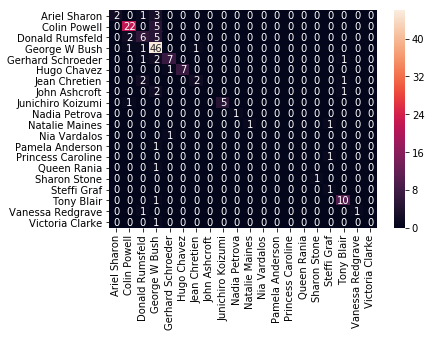

In [176]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)
sn.heatmap(df_cm, annot=True)

Finally, let's print people's images with their real name and the person the model predicted. 

In [177]:
def plot_gender(gender):
    samples = [i for i in range(y_test.shape[0])
               if genders[target_names[y_test[i]]] == gender]
    
    if len(samples) > 12:
        samples = samples[:12]
    
    curr_y_pred = [y_pred[i] for i in samples]
    curr_y_test = [y_test[i] for i in samples]
    curr_target_names = [target_names[y_test[i]] for i in samples]
    curr_X_test = [X_test[i] for i in samples]
    
    prediction_titles = ['gold: {gold_name}\npredicted: {pred_name}'.format(
        pred_name=target_names[y_pred[i]].split()[-1],
        gold_name=target_names[y_test[i]].split()[-1]) 
                         for i in samples]
    
    plot_gallery(curr_X_test, prediction_titles, h, w)
    plt.show()

Male:



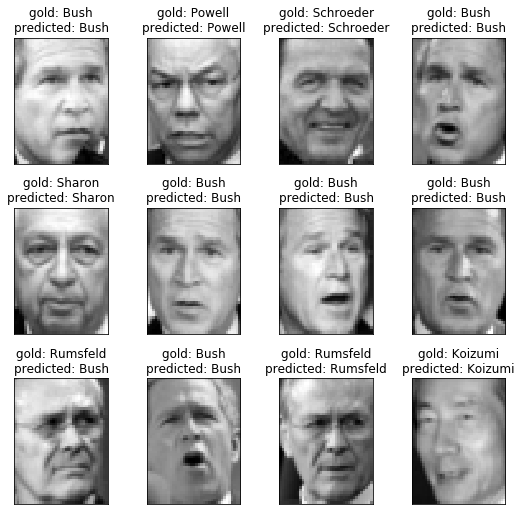

In [178]:
print('Male:\n')
plot_gender('male')   

Female:



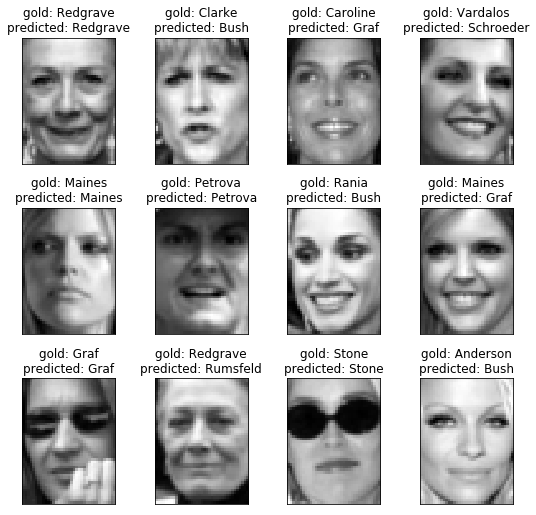

In [179]:
print('Female:\n')
plot_gender('female')  

To sum up, we saw that the model's performance on the average case can be misleading. In this case, the overall performance ($F_1$) was in the 70s, but breaking it down to genders shows that the performance for females is much worse (around 40). It is unsurprising given that we deliberately created a very skewed dataset, but similar things happen all the time in real-world applications. 